In [1]:
import os
import re
import numpy as np
import pandas as pd
from scipy.io.wavfile import write
from IPython.display import Audio

import rich
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from audiomentations import Gain,Normalize,LoudnessNormalization,AddGaussianSNR,Compose,Limiter,ClippingDistortion

In [2]:
DEFAULT_FS = 44100

In [3]:
class TestToneEvalClass:
    def __init__(self, duration, samplerate, frequency, filefold):
        self.samplerate = samplerate
        self.frequency = frequency
        self.duration = duration
        self.filefold = filefold
    
    def SinWaveGenerator(self):
        t = np.linspace(0, self.duration, int(self.duration * self.samplerate), endpoint=False)
        sine = np.sin(2 * np.pi * self.frequency * t)
        return sine

    def Adding_WNSNR(self, snr_db, data):
        if(snr_db != 0):
            Audio_Transform = AddGaussianSNR(min_snr_db=snr_db,max_snr_db=snr_db,p=1.0)
            data = Audio_Transform(data, sample_rate=self.samplerate)
        return data

    def Add_HummingSNR(self, snr_db, audio_signal, frequencies):
        #if amplitudes is None:
        # Set default amplitude to 0.5 for all frequencies if not provided
        #    amplitudes = [0.5] * len(frequencies)
        if (snr_db>0):
            originalRMS = self.Calculate_rms(audio_signal)
            print(f"The original level of signal is {originalRMS}")
            noise_RMS = self.Calculate_desired_noise_rms(originalRMS,snr_db)
            print(f"The noise level of signal is {noise_RMS}dB")
            noise_amplitude = self.Convert_decibels_to_amplitude_ratio(noise_RMS)
            print(f"comparing to adding noise with {noise_amplitude}")

            # Create a time array based on the length of the audio signal
            t = np.arange(len(audio_signal)) / self.samplerate

            # Initialize the new signal as a copy of the original audio signal
            new_audio_signal = np.copy(audio_signal)

            # Add each sine wave to the audio signal
            for freq in frequencies:
                sine_wave = noise_RMS * np.sin(2 * np.pi * freq * t)
                new_audio_signal += sine_wave
            return new_audio_signal
        else:
            return audio_signal

    def Adding_Limiter(self,data,thres_db,attac_time=0.0001,reles_time=0.0001):
        if(thres_db != 0):
            Audiomentations_Transform = Limiter(min_threshold_db=-thres_db,max_threshold_db=-thres_db,min_attack=attac_time,max_attack=attac_time,min_release=reles_time,max_release=reles_time,threshold_mode="relative_to_signal_peak",p=1.0)
#            Audiomentations_Transform = Limiter(min_threshold_db=-thres_db,max_threshold_db=-thres_db,min_attack=0.0005,max_attack=0.0005,min_release=0.05,max_release=0.05,threshold_mode="relative_to_signal_peak",p=1.0)
            data = Audiomentations_Transform(data, sample_rate=self.samplerate )
        return data
        
    def Adding_Clipping(self, samples, sample_rate, clipping_rate):
        if clipping_rate != 0:
            print("starting clipping")
            clipping_rate = round(clipping_rate, 1)
            lower_percentile_threshold = clipping_rate / 2
            lower_threshold, upper_threshold = np.percentile(
                samples, [lower_percentile_threshold, 100 - lower_percentile_threshold]
            )
            samples = np.clip(samples, lower_threshold, upper_threshold)
        return samples

    
    def DropingSamplesByPercentage(self, percentage, data):
        if(percentage > 0 and percentage < 1):
            num_samples = len(data)
            num_samples_to_drop = int(percentage*num_samples)
            drop_indices = np.random.choice(num_samples,num_samples_to_drop,replace=False)
            remapping_data = data
            remapping_data[drop_indices] = 0
        return remapping_data
    
    def DropingSamplesByNum(self, drop_samplenum, data):
        if(drop_samplenum > 0):
            num_samples = len(data)
            drop_indices = np.random.choice(num_samples,drop_samplenum,replace=False)
            data[drop_indices] = 0
        return data
    
    def PlotTimeSignal(self,data):
        time = np.linspace(0., duration, len(data))  # Time values for each sample 
        plt.figure(figsize=(10,4))
        plt.plot(time,data,label="Waveform")
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.ylim(-1.1, 1.1)
        plt.title('Waveform of the Audio')
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.show()

    def PlotFFT(self,data):
        data = data / np.max(np.abs(data))
        window = np.hanning(len(data))  
        y_windowed = data * window  
        
        # Zero-pad to increase FFT resolution
        #N = 2**16  # Larger FFT size (e.g., 16384)
        fft_result = np.fft.fft(y_windowed, n=len(data))
        frequencies = np.fft.fftfreq(len(data), d=1/self.samplerate)
        
        # Keep only the positive half of the spectrum
        half_N = len(data) // 2
        fft_magnitude = np.abs(fft_result[:half_N]) / len(data)
        fft_magnitude_db = 20 * np.log10(fft_magnitude + 1e-12)
        frequencies = frequencies[:half_N]
        
        # Plot FFT with log scale
        plt.figure(figsize=(10, 4))
        plt.plot(frequencies, fft_magnitude_db, color='b')
        plt.xscale("log")  # Logarithmic frequency axis
        plt.xlabel("Frequency (Hz)", fontsize=14)
        plt.ylabel("Magnitude (dB)", fontsize=14)
        plt.title("Enhanced FFT Spectrum (Log Scale)", fontsize=16)
        plt.grid()
        plt.ylim(-120, 0)
        plt.show()
        
    def SignalFileGenerator(self, audiodata, filename):
        ##by default all the data will be nomalized
        Normalize_Transform = Normalize(p=1.0)
        audiodata = Normalize_Transform(audiodata,self.samplerate)
        write(self.filefold+filename, self.samplerate, audiodata)
        return self.filefold+filename

    def Mp3MixingFileGenerator(self,audiodata,filename,bitrate=64):
        #the single file set to LUFS -14
        Lufs_Transform = LoudnessNormalization(min_lufs=-14.0,max_lufs=-14.0,p=1.0)
        mixing_data = Lufs_Transform(audiodata, self.samplerate)
        tmp_file = self.SignalFileGenerator(mixing_data, filename)
        command_out = os.popen("sh /home/codecrack/Jnotebook/CODECbreakCode/Audio_LameCompress.sh -a %s -b %s " %(tmp_file,bitrate)).read()
        match = re.search(r"outputMp3toWavfilepath=\s*(.+?)\s+by FFMPEG", command_out)
        if match:
            file_path = match.group(1)  # Capture the file path
            return file_path
        else:
            print("File path not found in the output.") 
            return "File path not found in the output."
        
        
    def Calculate_desired_noise_rms(self,clean_rms, snr):
        a = float(snr) / 20
        noise_rms = clean_rms / (10**a)
        return noise_rms
    
    def Convert_decibels_to_amplitude_ratio(self,decibels):
        return 10 ** (decibels / 20)
    
    def Calculate_rms(self,samples):
        return np.sqrt(np.mean(np.square(samples)))


In [4]:
import numpy as np
import clarity
import clarity.evaluator.haaqi as haaqi
import librosa
from clarity.utils.audiogram import Audiogram
class MeasureHAAQIOutput:
    '''The HAAQI becasue its with some configurations, it runs as a class to be able to set the configurations'''
    def __init__(self, ref_audio_path, levels_1 = np.array([0, 0, 0, 0, 0, 0, 0, 0])):
        '''The function is used to initialize the HAAQI class with the reference audio path and hearing loss levels(No heraring loss).'''
        self._audiogram_NH_ = Audiogram(levels=levels_1)
        self._reference_audio_data_, self._srate_ = librosa.load(ref_audio_path, sr=None)
        
    def set_reference_audio_data(self, ref_audio_path):
        '''The function is used to set the reference audio data.'''
        self._reference_audio_data_, self._srate_ = librosa.load(ref_audio_path, sr=None)

    def MeasureHAQQIOutput(self, com_audio_path):
        '''The function is used to measure the HAAQI score of the reference file and its codec counterpart.'''
        com_audio_data, _ = librosa.load(com_audio_path, sr=None)
        #return round(haaqi.compute_haaqi(com_audio_data, self._reference_audio_data_, self._srate_, self._srate_, self._audiogram_NH_),2)
        return haaqi.compute_haaqi(com_audio_data, self._reference_audio_data_, self._srate_, self._srate_, self._audiogram_NH_)

In [9]:
## duration on second
duration = 1
samplerate = DEFAULT_FS
frequency = 225
output_fold = '/home/codecrack/Jnotebook/TestTone_44k1/'

sineTone = TestToneEvalClass(duration, samplerate, frequency, output_fold)
sinewave = sineTone.SinWaveGenerator()
SinReferFile = sineTone.SignalFileGenerator(sinewave,f"TestTone_{frequency}Hz.wav" )

/root/anaconda3/lib/python3.11/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


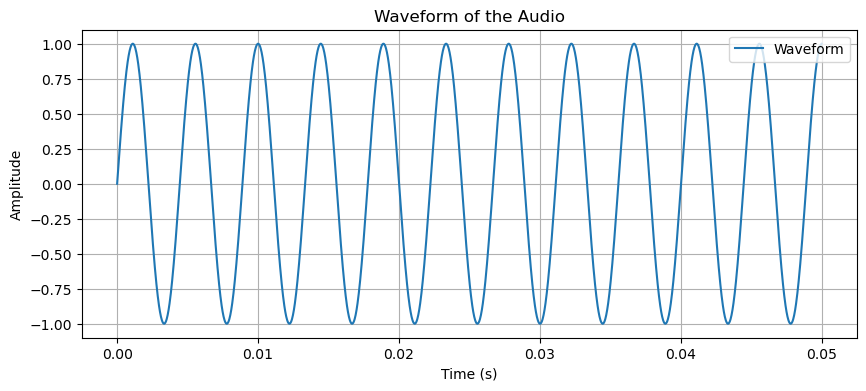

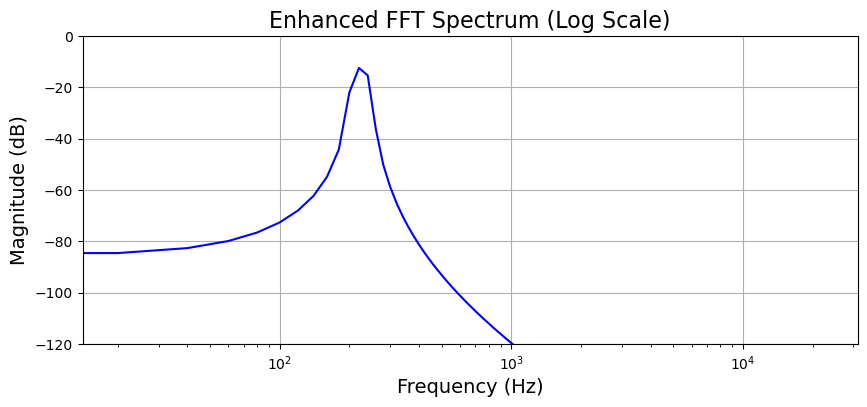

In [8]:
sineTone.PlotTimeSignal(sinewave)
sineTone.PlotFFT(sinewave)
Audio(sinewave, rate=samplerate)

In [11]:
ref_mp3 = sineTone.Mp3MixingFileGenerator(sinewave,"TestTone_{frequency}Hz_Mp3.wav",bitrate=64)
MeasureHAAQI = MeasureHAAQIOutput(ref_mp3)#Initilize the HAAQI with a permanent reference
MeasureHAAQI.MeasureHAQQIOutput(ref_mp3) #Test on how far from itself to itself

/root/anaconda3/lib/python3.11/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
Unknown encoder 'pcm_s25le'


0.7305407534666327

In [8]:
ref_mp3

'/home/codecrack/Jnotebook/Mixing_Result_Mp3_Wav/tmp_audio_64kbps.wav'

starting clipping


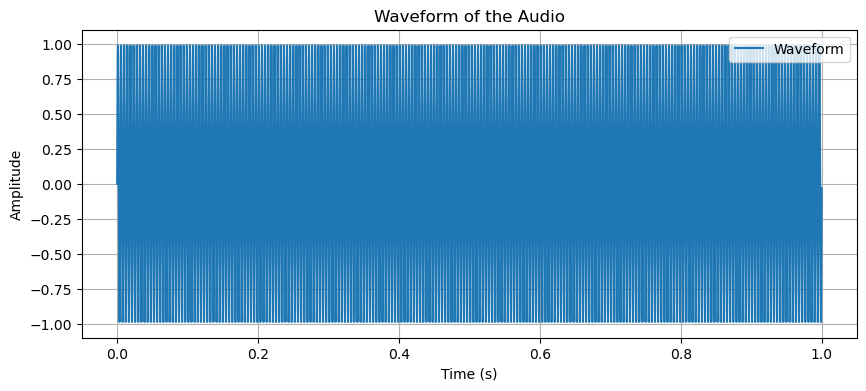

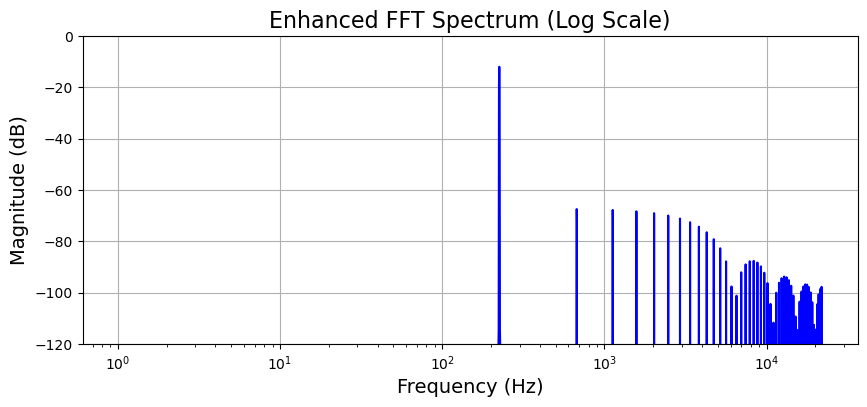

In [13]:
Audio_clip = sineTone.Adding_Clipping(sinewave, samplerate, 10)
sineTone.PlotTimeSignal(Audio_clip)
sineTone.PlotFFT(Audio_clip)
Audio(Audio_clip, rate=samplerate)

In [14]:
clipping_mp3 = sineTone.Mp3MixingFileGenerator(Audio_clip,"TestTone_{frequency}Hz_Mp3.wav",bitrate=64)
#MeasureHAAQI = MeasureHAAQIOutput(ref_mp3)#Initilize the HAAQI with a permanent reference
#MeasureHAAQI.MeasureHAQQIOutput(clipping_mp3) #Test on how far from itself to itself

/root/anaconda3/lib/python3.11/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
Unknown encoder 'pcm_s25le'


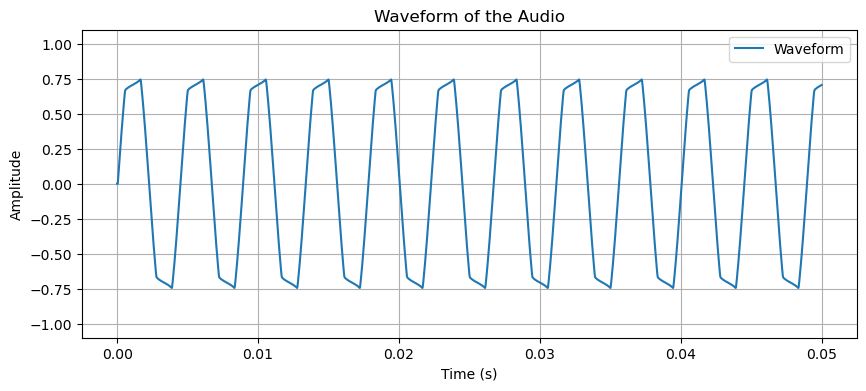

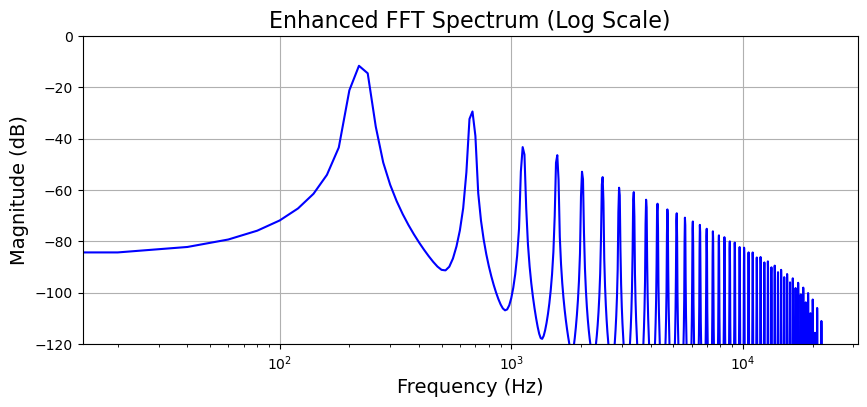

In [10]:
Audio_limiter = sineTone.Adding_Limiter(sinewave, 3)
sineTone.PlotTimeSignal(Audio_limiter)
sineTone.PlotFFT(Audio_limiter)
Audio(Audio_limiter, rate=samplerate)

In [11]:
import sys
sys.path.append('/home/codecrack/Jnotebook/')

In [12]:
from CODECbreakCode.compressor_qmul import Compressor

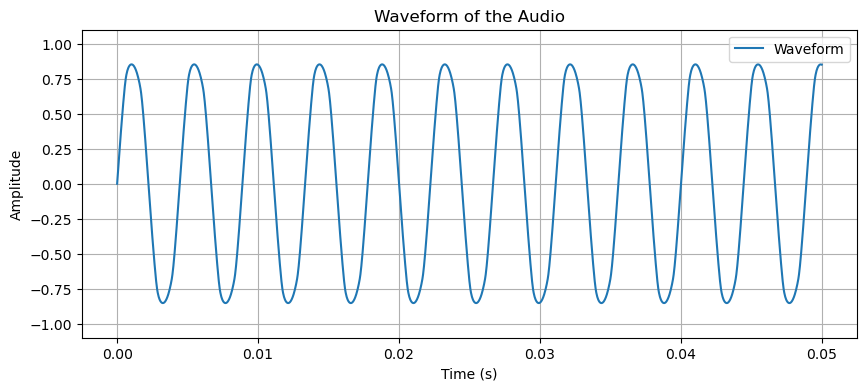

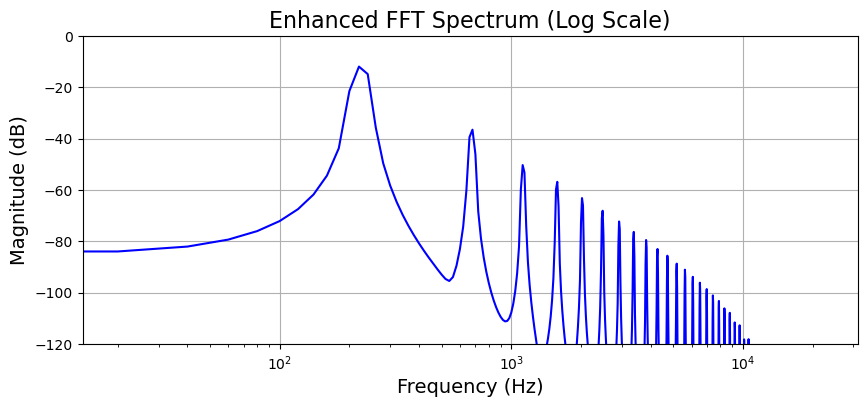

In [17]:
compressor = Compressor(
    threshold=-3.0,
    ratio=2,
    attack=0.1,
    release=0.1,
    makeup_gain=0.0,
    knee_width=1.0,
    sample_rate=samplerate,
)
#c.set_attack(10)
org_signal_sinewave = sinewave[np.newaxis, :]
compressed_signal = compressor(org_signal_sinewave)
sineTone.PlotTimeSignal(compressed_signal[0])
sineTone.PlotFFT(compressed_signal[0])
Audio(compressed_signal[0], rate=samplerate)

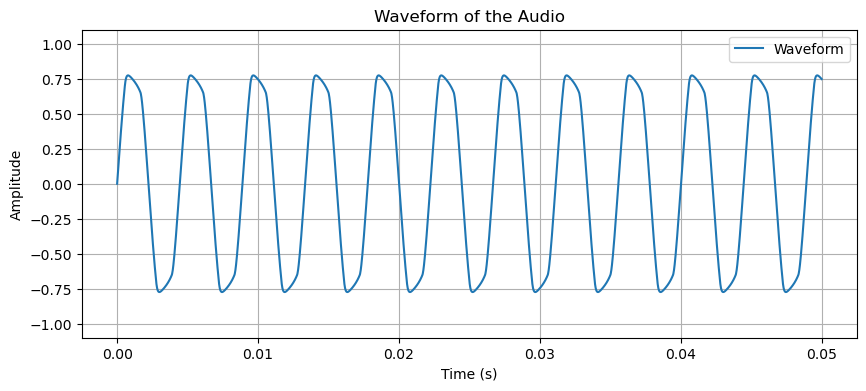

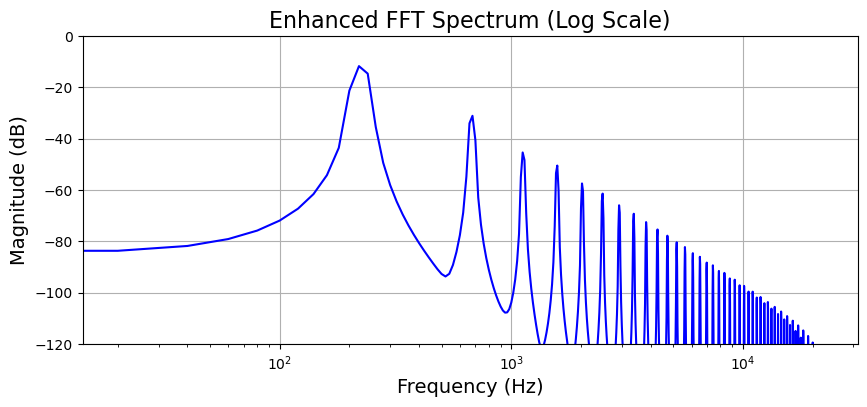

In [19]:
compressor_limiter = Compressor(
    threshold=-3.0,
    ratio=10,
    attack=0.1,
    release=0.1,
    makeup_gain=0.0,
    knee_width=0.0,
    sample_rate=samplerate,
)
#c.set_attack(10)
org_signal_sinewave = sinewave[np.newaxis, :]
compressed_limiter_signal = compressor_limiter(org_signal_sinewave)
sineTone.PlotTimeSignal(compressed_limiter_signal[0])
sineTone.PlotFFT(compressed_limiter_signal[0])
Audio(compressed_limiter_signal[0], rate=samplerate)

In [14]:
compressed_signal = compressor(signal)

In [35]:
np.exp(-1.0 / (0.001 * 44100 * 1))

0.9775794252591526

In [29]:
np.exp(-1.0)

0.36787944117144233

In [38]:
ratio = 2
knee_width = 0.9
threshold = 0.99

((1 / ratio - 1)* (0.99 - threshold + knee_width / 2) ** 2) / (2 * knee_width)

-0.05625

In [3]:
20 * np.log10(np.abs(0.75))

-2.4987747321659985